# TensorFlow Tutorial #02
# Convolutional Neural Network

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

The previous tutorial showed that a simple linear model had about 91% classification accuracy for recognizing hand-written digits in the MNIST data-set.

In this tutorial we will implement a simple Convolutional Neural Network in TensorFlow which has a classification accuracy of about 99%, or more if you make some of the suggested exercises.

Convolutional Networks work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image. This makes the Convolutional Networks much more powerful than Fully-Connected networks with the same number of variables. This in turn makes the Convolutional Networks faster to train.

You should be familiar with basic linear algebra, Python and the Jupyter Notebook editor. Beginners to TensorFlow may also want to study the first tutorial before proceeding to this one.

## Flowchart

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below.

![Flowchart](images/02_network_flowchart.png)

The input image is processed in the first convolutional layer using the filter-weights. This results in 16 new images, one for each filter in the convolutional layer. The images are also down-sampled so the image resolution is decreased from 28x28 to 14x14.

These 16 smaller images are then processed in the second convolutional layer. We need filter-weights for each of these 16 channels, and we need filter-weights for each output channel of this layer. There are 36 output channels so there are a total of 16 x 36 = 576 filters in the second convolutional layer. The resulting images are down-sampled again to 7x7 pixels.

The output of the second convolutional layer is 36 images of 7x7 pixels each. These are then flattened to a single vector of length 7 x 7 x 36 = 1764, which is used as the input to a fully-connected layer with 128 neurons (or elements). This feeds into another fully-connected layer with 10 neurons, one for each of the classes, which is used to determine the class of the image, that is, which number is depicted in the image.

The convolutional filters are initially chosen at random, so the classification is done randomly. The error between the predicted and true class of the input image is measured as the so-called cross-entropy. The optimizer then automatically propagates this error back through the Convolutional Network using the chain-rule of differentiation and updates the filter-weights so as to improve the classification error. This is done iteratively thousands of times until the classification error is sufficiently low.

These particular filter-weights and intermediate images are the results of one optimization run and may look different if you re-run this Notebook.

Note that the computation in TensorFlow is actually done on a batch of images instead of a single image, which makes the computation more efficient. This means the flowchart actually has one more data-dimension when implemented in TensorFlow.

## Convolutional Layer

The following chart shows the basic idea of processing an image in the first convolutional layer. The input image depicts the number 7 and four copies of the image are shown here, so we can see more clearly how the filter is being moved to different positions of the image. For each position of the filter, the dot-product is being calculated between the filter and the image pixels under the filter, which results in a single pixel in the output image. So moving the filter across the entire input image results in a new image being generated.

The red filter-weights means that the filter has a positive reaction to black pixels in the input image, while blue pixels means the filter has a negative reaction to black pixels.

In this case it appears that the filter recognizes the horizontal line of the 7-digit, as can be seen from its stronger reaction to that line in the output image.

![Convolution example](images/02_convolution.png)

The step-size for moving the filter across the input is called the stride. There is a stride for moving the filter horizontally (x-axis) and another stride for moving vertically (y-axis).

In the source-code below, the stride is set to 1 in both directions, which means the filter starts in the upper left corner of the input image and is being moved 1 pixel to the right in each step. When the filter reaches the end of the image to the right, then the filter is moved back to the left side and 1 pixel down the image. This continues until the filter has reached the lower right corner of the input image and the entire output image has been generated.

When the filter reaches the end of the right-side as well as the bottom of the input image, then it can be padded with zeroes (white pixels). This causes the output image to be of the exact same dimension as the input image.

Furthermore, the output of the convolution may be passed through a so-called Rectified Linear Unit (ReLU), which merely ensures that the output is positive because negative values are set to zero. The output may also be down-sampled by so-called max-pooling, which considers small windows of 2x2 pixels and only keeps the largest of those pixels. This halves the resolution of the input image e.g. from 28x28 to 14x14 pixels.

Note that the second convolutional layer is more complicated because it takes 16 input channels. We want a separate filter for each input channel, so we need 16 filters instead of just one. Furthermore, we want 36 output channels from the second convolutional layer, so in total we need 16 x 36 = 576 filters for the second convolutional layer. It can be a bit challenging to understand how this works.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import datetime
import math
import os
from scipy import ndimage
#import test4 as tst

This was developed using Python 3.6.1 (Anaconda) and TensorFlow version:

In [2]:
np

<module 'numpy' from '/Users/yaminigaur/anaconda3/lib/python3.7/site-packages/numpy/__init__.py'>

In [3]:
tf.__version__

'0.12.0'

## Configuration of Neural Network

The configuration of the Convolutional Neural Network is defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.

In [4]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [5]:
a = datetime.datetime.now()
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)
b = datetime.datetime.now()
c = b-a
print(c.microseconds)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
478305


The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [7]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [8]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

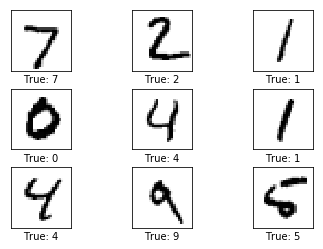

In [10]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [11]:
print(images[8])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

### Helper-functions for creating new variables

Functions for creating new TensorFlow variables in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.

In [12]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    

In [13]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper-function for creating a new Convolutional Layer

This function creates a new convolutional layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.

It is assumed that the input is a 4-dim tensor with the following dimensions:

1. Image number.
2. Y-axis of each image.
3. X-axis of each image.
4. Channels of each image.

Note that the input channels may either be colour-channels, or it may be filter-channels if the input is produced from a previous convolutional layer.

The output is another 4-dim tensor with the following dimensions:

1. Image number, same as input.
2. Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
3. X-axis of each image. Ditto.
4. Channels produced by the convolutional filters.

In [14]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    #layerConvOut = layer

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    #layer += biases

    return layer, weights, biases

In [15]:
def pooling_relu(input,              # The previous layer.
                  use_pooling=True):  # Use 2x2 max-pooling.


    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=input,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer

### Helper-function for flattening a layer

A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.

In [16]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### Helper-function for creating a new Fully-Connected Layer

This function creates a new fully-connected layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.

It is assumed that the input is a 2-dim tensor of shape `[num_images, num_inputs]`. The output is a 2-dim tensor of shape `[num_images, num_outputs]`.

In [17]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer,weights

### Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [18]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [19]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [20]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [21]:
y_true_cls = tf.argmax(y_true, axis=1)

### Convolutional Layer 1

Create the first convolutional layer. It takes `x_image` as input and creates `num_filters1` different filters, each having width and height equal to `filter_size1`. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

In [22]:
layer_conv1, weights_conv1,biases_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1)

### Add Biases

In [23]:
layer_conv1_biases = layer_conv1 + biases_conv1

### Pooling Relu Convolution Layer 1

In [24]:
layer_conv1_pool_relu = pooling_relu(input = layer_conv1_biases,use_pooling=True)

Check the shape of the tensor that will be output by the convolutional layer. It is (?, 14, 14, 16) which means that there is an arbitrary number of images (this is the ?), each image is 14 pixels wide and 14 pixels high, and there are 16 different channels, one channel for each of the filters.

In [25]:
x_image

<tf.Tensor 'Reshape:0' shape=(?, 28, 28, 1) dtype=float32>

### Convolutional Layer 2

Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.

In [26]:
layer_conv2, weights_conv2,biases_conv2 = \
    new_conv_layer(input=layer_conv1_pool_relu,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2)

### Adding Biases

In [27]:
layer_conv2_biases = layer_conv2 + biases_conv2

### Pooling Relu Convolution Layer 2

In [28]:
layer_conv2_pool_relu = pooling_relu(input = layer_conv2_biases,use_pooling=True)

Check the shape of the tensor that will be output from this convolutional layer. The shape is (?, 7, 7, 36) where the ? again means that there is an arbitrary number of images, with each image having width and height of 7 pixels, and there are 36 channels, one for each filter.

In [29]:
layer_conv2[1][:,:,1][:,:]

<tf.Tensor 'strided_slice_2:0' shape=(14, 14) dtype=float32>

In [30]:
 weights_conv2

### Flatten Layer

The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [31]:
layer_flat, num_features = flatten_layer(layer_conv2_pool_relu)

Check that the tensors now have shape (?, 1764) which means there's an arbitrary number of images which have been flattened to vectors of length 1764 each. Note that 1764 = 7 x 7 x 36.

In [32]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [33]:
num_features

1764

### Fully-Connected Layer 1

Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is `fc_size`. ReLU is used so we can learn non-linear relations.

In [34]:
layer_fc1,weights_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

Check that the output of the fully-connected layer is a tensor with shape (?, 128) where the ? means there is an arbitrary number of images and `fc_size` == 128.

In [35]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### Fully-Connected Layer 2

Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.

In [36]:
layer_fc2,weights_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [37]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

### Predicted Class

The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in `y_pred`.

In [38]:
y_pred = tf.nn.softmax(layer_fc2)

In [39]:
print(y_pred)

Tensor("Softmax:0", shape=(?, 10), dtype=float32)


The class-number is the index of the largest element.

In [40]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model `y_pred` to the desired output `y_true`.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.

TensorFlow has a built-in function for calculating the cross-entropy. Note that the function calculates the softmax internally so we must use the output of `layer_fc2` directly rather than `y_pred` which has already had the softmax applied.

In [41]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [42]:
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the `AdamOptimizer` which is an advanced form of Gradient Descent.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [43]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image.

In [44]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [45]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [46]:
session = tf.Session()

### Save Session

In [47]:
saver = tf.train.Saver()

In [48]:
save_dir = 'checkpoints_lenetMinst/'

In [49]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [50]:
save_path = os.path.join(save_dir, 'best_validation')

### Restore saved session

In [51]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
Restored checkpoint from: checkpoints_lenetMinst/best_validation-7000


### Initialize variables

The variables for `weights` and `biases` must be initialized before we start optimizing them.

In [52]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [53]:
train_batch_size = 64

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [54]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))
            
      
        if (total_iterations % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step = total_iterations)

            print("Saved checkpoint.")
            
        total_iterations += 1


    # Update the total number of iterations performed.
    #total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [55]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [56]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [57]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance before any optimization

The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [58]:
print_test_accuracy()

Accuracy on Test-Set: 9.4% (938 / 10000)


## Performance after 1 optimization iteration

The classification accuracy does not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low.

In [59]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  12.5%
Saved checkpoint.
Time usage: 0:00:01


In [60]:
a = time.time()
print_test_accuracy()
b = time.time()
c = b-a
print(c)

Accuracy on Test-Set: 11.4% (1136 / 10000)
4.472064018249512


## Performance after 100 optimization iterations

After 100 optimization iterations, the model has significantly improved its classification accuracy.

In [61]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Saved checkpoint.
Time usage: 0:00:07


Accuracy on Test-Set: 67.2% (6725 / 10000)
Example errors:


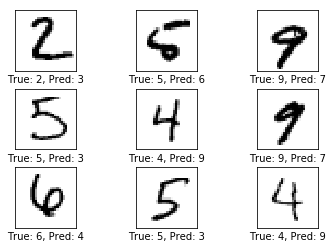

In [62]:
print_test_accuracy(show_example_errors=True)

## Performance after 1000 optimization iterations

After 1000 optimization iterations, the model has greatly increased its accuracy on the test-set to more than 90%.

In [63]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  75.0%
Optimization Iteration:    201, Training Accuracy:  81.2%
Optimization Iteration:    301, Training Accuracy:  75.0%
Optimization Iteration:    401, Training Accuracy:  85.9%
Optimization Iteration:    501, Training Accuracy:  87.5%
Optimization Iteration:    601, Training Accuracy:  95.3%
Optimization Iteration:    701, Training Accuracy:  87.5%
Optimization Iteration:    801, Training Accuracy:  92.2%
Saved checkpoint.
Optimization Iteration:    901, Training Accuracy:  89.1%
Time usage: 0:01:02


Accuracy on Test-Set: 93.0% (9304 / 10000)
Example errors:


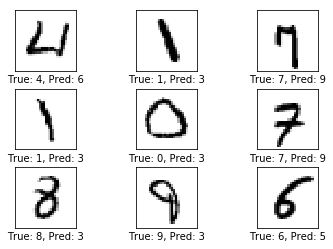

In [64]:
print_test_accuracy(show_example_errors=True)

In [65]:
total_iterations

1000

## Performance after 10,000 optimization iterations

After 10,000 optimization iterations, the model has a classification accuracy on the test-set of about 99%.

In [66]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1001, Training Accuracy:  93.8%
Saved checkpoint.
Optimization Iteration:   1101, Training Accuracy:  92.2%
Optimization Iteration:   1201, Training Accuracy:  95.3%
Optimization Iteration:   1301, Training Accuracy:  98.4%
Optimization Iteration:   1401, Training Accuracy:  98.4%
Optimization Iteration:   1501, Training Accuracy:  95.3%
Optimization Iteration:   1601, Training Accuracy:  92.2%
Optimization Iteration:   1701, Training Accuracy:  95.3%
Optimization Iteration:   1801, Training Accuracy:  96.9%
Optimization Iteration:   1901, Training Accuracy:  98.4%
Optimization Iteration:   2001, Training Accuracy:  93.8%
Saved checkpoint.
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy: 100.0%
Optimization Iteration:   2301, Training Accuracy: 100.0%
Optimization Iteration:   2401, Training Accuracy:  96.9%
Optimization Iteration:   2501, Training Accuracy:  96.9%
Optimization Iteration:   2601, Trai

Accuracy on Test-Set: 98.9% (9892 / 10000)
Example errors:


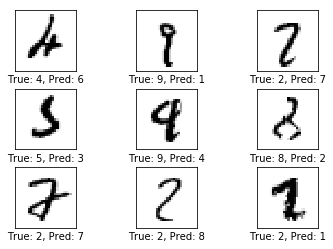

Confusion Matrix:
[[ 974    0    1    0    0    0    2    1    2    0]
 [   0 1133    1    0    0    0    0    1    0    0]
 [   1    3 1015    0    1    0    0    5    7    0]
 [   0    0    0 1005    0    2    0    1    2    0]
 [   0    0    0    0  979    0    2    0    0    1]
 [   2    0    0    5    0  881    3    0    0    1]
 [   2    3    0    0    2    2  949    0    0    0]
 [   0    3    7    1    0    0    0 1016    1    0]
 [   2    0    1    2    2    1    0    2  962    2]
 [   1    6    0    2   12    4    0    4    2  978]]


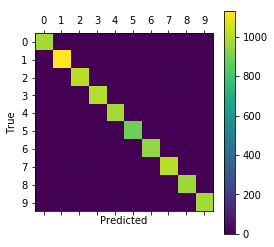

In [72]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Store the original weights

In [73]:
w_conv1_original = session.run(weights_conv1)
w_conv2_original = session.run(weights_conv2)
w_fc1_original = session.run(weights_fc1)
w_fc2_original = session.run(weights_fc2)

In [74]:
w_fc2_original.shape

(128, 10)

In [75]:
wOrigConv = [w_conv1_original,w_conv2_original]
wOrigFc = [w_fc1_original, w_fc2_original]

In [76]:
w_conv1_original[:,:,0,1]

array([[-0.14730863, -0.17305252, -0.25539148, -0.12766491, -0.05200694],
       [-0.21200274, -0.24868067, -0.11528031, -0.02846441,  0.06710728],
       [ 0.00370491,  0.07936205,  0.13816267,  0.11260455,  0.16347203],
       [ 0.21157406,  0.19562273,  0.08887535,  0.08664314,  0.08589598],
       [ 0.1574995 ,  0.22077192,  0.05880862,  0.05066765, -0.00425202]],
      dtype=float32)

In [77]:
w_conv2_original[:,:,15,35]

array([[ 0.11203958,  0.0857379 ,  0.00021456,  0.0642254 , -0.06366021],
       [ 0.03796512, -0.01055547,  0.04040334, -0.00794536,  0.08250369],
       [ 0.03824591,  0.02763841,  0.01552453,  0.01314175,  0.0712262 ],
       [ 0.10982627,  0.02202161, -0.03877726,  0.0018859 ,  0.15788636],
       [ 0.02697983,  0.10313573, -0.03673745, -0.00675308,  0.04836358]],
      dtype=float32)

## Restore Original Weights

In [78]:
def restoreWeights():
    for wIdx in range(0,len(weightsConvMat)):
            assign_op = weightsConvMat[wIdx].assign(wOrigConv[wIdx])
            session.run(assign_op)

    for wIdx in range(0,len(weightsFcMat)):
            assign_op = weightsFcMat[wIdx].assign(wOrigFc[wIdx])
            session.run(assign_op)

In [637]:
restoreWeights()

## Create list of weights_conv and assign to alternate varialbles

# This is the point of contraption where we will re run from each time in order to calculate our ME values

weightsConvMat is a list of weights of convolution layer 1 and convolution layer 2. 
Similarly, weightsFcMat is a list of weights of FC layer 1 and FC layer 2. 
We are going with the assumption that weightsConvMat and weightsFcMat holds the original weights and then wConv and wFc 
are the lists that we modify

In [638]:
weightsConvMat = [weights_conv1,weights_conv2]
weightsFcMat = [weights_fc1, weights_fc2]

wConv1 = session.run(weights_conv1)
wConv2 = session.run(weights_conv2)

wFc1 = session.run(weights_fc1)
wFc2 = session.run(weights_fc2)

wConv = [wConv1,wConv2]
wFc = [wFc1,wFc2]

In [639]:
wConv[1].shape

(5, 5, 16, 36)

## Create List that will hold the difference between 2 filters

In [640]:
wDiffConv = [] + wOrigConv
wDiffFc = [] + wOrigFc

## Create Alternate Filters

### Negative values to zero

In [83]:
def roundToZeroFilter(wtListConv,wtListFc):
    num = len(wtListConv)
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        if wtMat[j,k,c,i] < 0:
                            wtMat[j,k,c,i] = 0#float('%.5f'%(w[j,k,0,i]))
                            
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                if wtMat[i,j] < 0:
                    wtMat[i,j] = 0
                j=j+1;


#roundToZeroFilter(w)

### Centroid based averaging filter

In [84]:
def centroidFilter(wtListConv,wtListFc):
    num = len(wtListConv)
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen,2):
                    for k in range(0,ylen,2):
                        first = wtMat[j,k,c,i]
                        if j+1 < xlen:
                            second = wtMat[j+1,k,c,i]
                        else:
                            second = 0
                        if k+1 < xlen:
                            third = wtMat[j,k+1,c,i]
                        else:
                            third = 0
                        if j+1 < xlen and k+1 < ylen:
                            forth = wtMat[j+1,k+1,c,i]
                        else:
                            forth = 0
                        total = 0.0
                        total = float(first + second + third + forth)
                        total /= 4
                        wtMat[j,k,c,i] = total
                        if j+1 < xlen:
                            wtMat[j+1,k,c,i] = total
                        if k+1 < xlen:
                            wtMat[j,k+1,c,i] = total
                        if j+1 < xlen and k+1 < ylen:
                            wtMat[j+1,k+1,c,i] = total
                        #if wtMat[j,k,0,i] < 0:
                        #    wtMat[j,k,0,i] = 0#float('%.5f'%(w[j,k,0,i]))
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                first = wtMat[i,j] 
                second = wtMat[i,j+1]
                avg = (first+second)/2
                wtMat[i,j] = avg
                wtMat[i,j+1] = avg
                j = j+2
            


#centroidFilter(w)

### Truncating the decimal 

In [85]:
def truncateFilter(wtListConv,wtListFc):
    num = len(wtListConv)
    
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))
                        
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                wtMat[i,j]=float('%.5f'%(wtMat[i,j]))
                j=j+1;

                        
    
#truncateFilter(w)

In [86]:
def borderFilter(wtListConv):
   
   for wtMat in wtListConv:
       shape = wtMat.shape
       xlen = shape[0]
       ylen = shape[1]
       numChnls = shape[2]
       numFilters = shape[3]

       for c in range(0,numChnls):
           for i in range(0,numFilters):
               for j in range(0, xlen):
                   for k in range(0,ylen):
                       if(k%4 == 0 or j%4 == 0):
                           wtMat[j,k,c,i] = 0

In [87]:
def borderFilterFc(wtListFc):
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for c in range(0,xlen):
            for k in range(0,ylen):
                if(k%4==0 or c%4==0):
                    wtMat[c,k] = 0

## This is where we assign the alternative filters to replace the original filter in static approx

In [641]:
#truncateFilter(wConv,wFc)
#roundToZeroFilter(wConv, wFc)
#centroidFilter(wConv, wFc)
## should we be changing the filter here?
borderFilter(wConv)
borderFilterFc(wFc)
#truncateFilter(w)

In [642]:
wFc

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.05115661, -0.0106145 , ...,  0.0692575 ,
         -0.04895232,  0.02969031],
        [ 0.        ,  0.05768923, -0.01017315, ...,  0.01961088,
         -0.01465359,  0.06076228],
        ...,
        [ 0.        ,  0.01220994, -0.02990404, ...,  0.00767086,
         -0.07688827,  0.06376908],
        [ 0.        ,  0.00403171,  0.0768006 , ...,  0.01471539,
         -0.01255059, -0.02636899],
        [ 0.        , -0.02793574,  0.06977787, ..., -0.06329624,
          0.07734483, -0.05417221]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.08150284, -0.01011836, ...,  0.13920817,
          0.        , -0.00110414],
        [ 0.        ,  0.12779841,  0.05866146, ...,  0.01651865,
          0.        , -0.01599188],
        ...,
        [ 0.        ,  0.01213235,  0.0

In [643]:
checkSumConvLayer1 = []
checkSumConvLayer2 = []
checkSumFCLayer1 = []
checkSumFCLayer2 = []

## Testing and Assigning the alternate filters

In [531]:
def assignFilters(wConv,wFc):
    for wIdx in range(0,len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wConv[wIdx])
        session.run(assign_op)
        
    for wIdx in range(0,len(weightsFcMat)):
        assign_op = weightsFcMat[wIdx].assign(wFc[wIdx])
        session.run(assign_op)
    
#     a = time.time()
#     print_test_accuracy()
#     b = time.time()
#     c = b-a
#     print(c)


Here, we are assigning the ORIGINAL filters for each layer in the session

In [644]:
assignFilters(wConv,wOrigFc)

In [618]:
a = time.time()
print_test_accuracy()
b = time.time()
c = b-a
print(c)


Accuracy on Test-Set: 32.1% (3207 / 10000)
3.6801059246063232


## Multiplication Error

### Loading Image Data

In [97]:
def loadValues(numImg):
    #numImg = 100
    image1 = data.test.images[0:numImg]
    feed_dict = {x: image1}
    values_conv1 = session.run(layer_conv1, feed_dict=feed_dict)
    values_conv2 = session.run(layer_conv2, feed_dict=feed_dict)
    values_fc1 = session.run(layer_fc1, feed_dict=feed_dict)
    values_fc2 = session.run(layer_fc2, feed_dict = feed_dict)
    valuesConvMat = [values_conv1,values_conv2]
    valuesFcMat = [values_fc1, values_fc2]
    return valuesConvMat, valuesFcMat,numImg

### Calculating ME for Conv Layer

In [436]:
def calculateConvME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[3]
   ## print("we are in the calculateConvME function")
   ## print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    print("the number of filters are")
    print(numFilters)
    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0,numFilters):
            result = valMat[nImg,:,:,i]
            result_sum = np.sum(result)
            means[i] = result_sum

    average = [x / numImg for x in meanSum]
    averageSorted = np.sort(average)
    return average, averageSorted

In [99]:
def calculateFCME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[1]
    ##print("we are in the fully connected layer function")
    ##print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)

    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0,numFilters):
            result = valMat[nImg,i]
            result_sum = np.sum(result)
            means[i] = result_sum

    average = [x / numImg for x in meanSum]
    averageSorted = np.sort(average)
    return average, averageSorted

In [439]:
def calculateConvMEDynamic (valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[3]
   ## print("we are in the calculateConvME function")
   ## print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    print("the number of filters is ")
    print(numFilters)
    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0,numFilters):
            result = valMat[nImg,:,:,i]
            result_sum = np.sum(result)
            means[i] = result_sum

    ##sortedFirst = np.sort(meanSum)
    positiveSortedFirst = [] 
    
    for sort in meanSum:
        if sort<0:
            sort = sort*-1
            positiveSortedFirst.append(sort)
        else :
            positiveSortedFirst.append(sort)
        
    
    positiveSortedFirst = np.sort(positiveSortedFirst)
    print("the number of images is")
    print(numImg)
    average = [x / numImg for x in positiveSortedFirst]
    #print(average)
    #averageSorted = np.sort(average)
    return average
    

In [467]:
def calculateFCMEDynamic (valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[1]
    ##print("we are in the fully connected layer function")
    ##print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)

    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0,numFilters):
            result = valMat[nImg,i]
            result_sum = np.sum(result)
            means[i] = result_sum

    positiveSortedFirst = []
    for sort in meanSum:
        if sort<0:
            sort = sort*-1
        positiveSortedFirst.append(sort)
        
    positiveSortedFirst = np.sort(positiveSortedFirst)
    average = [x / numImg for x in positiveSortedFirst]
    #averageSorted = np.sort(average)
    return average

In [149]:
def plotME(ME):
    import numpy as np
    x = np.arrange(2)
    #print(ME)
    ypos = np.arange(len(ME))
    y = ME
    fig = plt.bar(ypos,y,align='center', label = 'work pls')
    
    fig.set_label('ME Values')
    ##fig.set_ylabel('Frequency')

In [173]:
def plotMEConvolution(ME1, ME2):
    import numpy as np
    x = np.arange(len(ME1))
    y = np.arange(len(ME2))
    plt.bar(x, ME1, color = 'b', align='center')
    plt.bar(y+17, ME2, color = 'g', align = 'center', label = 'does this work')
    
    
    #plt.bar()
    

In [202]:
def plotMEFullyConnected(ME1, ME2):
    import numpy as np
    x = np.arange(len(ME1))
    y = np.arange(len(ME2))
    plt.bar(x, ME1, color = 'b', align = 'center')
    plt.bar(y + 129, ME2, color = 'g', align = 'center')
    

### Filter Policy (20% of the Top filters)

In [101]:
def newApproxFilters(ME,wConvNew,wOrigConv):
    sortedME = np.sort(ME)
    length = len(ME)
    thresh = (int)(length*0.8)
    threshVal = sortedME[thresh]

    shape = wConvNew.shape
    numChnls = shape[2]
    numFilters = shape[3]
    print("the number of filters in this layer are")
    print(numFilters)
    for i in range(0,numFilters):
        if ME[i] >= threshVal:
            wConvNew[:,:,:,i] = wOrigConv[:,:,:,i]

In [102]:
def newApproxFiltersForFullyConnected(ME,wFullyConnectedNew,wOrigFc):
    sortedME = np.sort(ME)
    length = len(ME)
    thresh = (int)(length*0.8)
    threshVal = sortedME[thresh]

    shape = wFullyConnectedNew.shape
    #numChnls = shape[2]
    numFilters = shape[1]
    print("the number of filters in this layer are")
    print(numFilters)
    for i in range(0,numFilters):
        if ME[i] >= threshVal:
            wFullyConnectedNew[:,i] = wOrigFc[:,i]

In [388]:
##roundToZeroFilter(wConv, wFc)

### Subtracting the two filters

This is ensuring that wConv and wOrigConv are the same at this stage. But i need to check whether we are doing the subtraction in our ME calculation. 

In [645]:
for i in range(len(wConv)):
    wDiffConv[i] = np.absolute(wOrigConv[i] - wConv[i])

In [646]:
for i in range(len(wFc)):
#print(wOrigFc[1].shape)
    wDiffFc[i] = np.absolute(wOrigFc[i] - wFc[i])

In [647]:
wDiffConv[0]

array([[[[0.00482545, 0.14730863, 0.07236488, 0.03228739, 0.13564014,
          0.11693471, 0.13347042, 0.07932844, 0.02281787, 0.04330307,
          0.06078885, 0.14764208, 0.14154744, 0.15705346, 0.0291781 ,
          0.10150275]],

        [[0.01899529, 0.17305252, 0.09831913, 0.0359213 , 0.0426936 ,
          0.09006342, 0.18557718, 0.08854203, 0.10383922, 0.13474256,
          0.07627146, 0.20606565, 0.18252592, 0.03997561, 0.00118396,
          0.19376722]],

        [[0.06314308, 0.25539148, 0.04741718, 0.0166559 , 0.06552761,
          0.02670347, 0.18234122, 0.07891496, 0.00512846, 0.10524219,
          0.0871951 , 0.17767873, 0.09471425, 0.12092065, 0.0512167 ,
          0.04419973]],

        [[0.01775191, 0.12766491, 0.16713016, 0.03448634, 0.18321727,
          0.02665561, 0.0955156 , 0.02191633, 0.06330841, 0.07235069,
          0.06936628, 0.15929246, 0.146179  , 0.16194744, 0.0107396 ,
          0.13173139]],

        [[0.08010492, 0.05200694, 0.05065684, 0.06646603, 0.

### Assign the values and Calculate the ME 

In [1077]:
#borderFilter(wConv)
#borderFilterFc(wFc)

In [622]:
wConv

[array([[[[0.00482545, 0.        , 0.        , 0.        , 0.13564014,
           0.11693471, 0.13347042, 0.07932844, 0.02281787, 0.04330307,
           0.06078885, 0.14764208, 0.14154744, 0.15705346, 0.        ,
           0.10150275]],
 
         [[0.01899529, 0.        , 0.09831913, 0.0359213 , 0.0426936 ,
           0.09006342, 0.18557718, 0.08854203, 0.        , 0.13474256,
           0.07627146, 0.20606565, 0.18252592, 0.03997561, 0.00118396,
           0.19376722]],
 
         [[0.        , 0.        , 0.04741718, 0.        , 0.        ,
           0.02670347, 0.18234122, 0.07891496, 0.        , 0.10524219,
           0.        , 0.17767873, 0.09471425, 0.12092065, 0.0512167 ,
           0.04419973]],
 
         [[0.        , 0.        , 0.16713016, 0.03448634, 0.        ,
           0.02665561, 0.0955156 , 0.02191633, 0.06330841, 0.07235069,
           0.        , 0.15929246, 0.146179  , 0.16194744, 0.0107396 ,
           0.        ]],
 
         [[0.08010492, 0.        , 0.050

## make sure where the filters are being assigned since that can affect how the filter weights appear

In [648]:
assignFilters(wConv,wOrigFc)

#------ this assign_op is only for assigning the first conv and first fc layer ------#

assign_op = weightsFcMat[0].assign(wDiffFc[0])
session.run(assign_op)
assign_op = weightsConvMat[0].assign(wDiffConv[0])
session.run(assign_op)

valuesConvMat, valuesFcMat, numImg = loadValues(100)

#MEConv1,MEConv1Sorted = calculateConvME(valuesConvMat[0])
MEConv1Sorted = calculateConvMEDynamic(valuesConvMat[0])

#MEConv2Static, MEConv2StaticSorted = calculateConvME(valuesConvMat[1])

#
#MEFullyConnected1, MEFullyConnected1Sorted = calculateFCME(valuesFcMat[0])
MEFullyConnected1Sorted = calculateFCMEDynamic(valuesFcMat[0])
#MEFullyConnected2Sorted = calculateFCMEDynamic(valuesFcMat[1])
assignFilters(wConv,wOrigFc)

assign_op = weightsConvMat[1].assign(wDiffConv[1])
session.run(assign_op)

valuesConvMat,valuesFcMat,numImg = loadValues(100)

#MEConv2,MEConv2Sorted = calculateConvME(valuesConvMat[1])

MEConv2Sorted = calculateConvMEDynamic(valuesConvMat[1])

# assign_op is used to assign weights to the actual network. Unless the weight assignment is done, the changes from 
# actual to approximate filters is not reflected in the system. 

#------ this assign_op is only for assigning the second conv and second fc layer ------#

assign_op = weightsFcMat[1].assign(wDiffFc[1])
session.run(assign_op)
valuesConvMat,valuesFcMat,numImg = loadValues(100)

#MEFullyConnected2, MEFullyConnected2Sorted = calculateFCME(valuesFcMat[1])
MEFullyConnected2Sorted = calculateFCMEDynamic(valuesFcMat[1])
#print("This is the ME for the convolution layer")
#print(MEConv2Sorted)

MEConvMat = [MEConv1Sorted, MEConv2Sorted]
#print(MEConv1Sorted)
MEFullyConnectedMat = [MEFullyConnected1Sorted, MEFullyConnected2Sorted]
#print(MEConv2Sorted)
#print("the ME of Conv2 from the static approximation is")
print(MEConv2Sorted)

the number of filters is 
16
the number of images is
100
the number of filters is 
36
the number of images is
100
[284.0943159484863, 288.8352099609375, 298.04502182006837, 305.32520172119143, 307.680401763916, 310.5993087768555, 312.8354042053223, 317.97241851806643, 319.5869285583496, 320.20006256103517, 320.6418853759766, 322.2294032287598, 322.29614456176756, 322.5850440979004, 326.6094387817383, 326.65364349365234, 326.7122821044922, 328.22751846313474, 333.48359313964846, 334.3026467895508, 334.41574966430665, 335.65382919311526, 336.5212094116211, 349.8987525939941, 355.77804122924806, 357.09387008666994, 358.87083557128904, 360.4236633300781, 363.7716474914551, 368.0089872741699, 368.81969665527345, 372.4162484741211, 385.30822982788084, 386.35286315917966, 396.9577099609375, 402.0483027648926]


In [649]:
MEFullyConnected1



[0.05109483987092972,
 0.05833905979990959,
 0.04691004622727633,
 0.05542403116822243,
 0.05688080444931984,
 0.05264612458646298,
 0.051166584938764574,
 0.05894976690411568,
 0.057829303927719594,
 0.0632626960426569,
 0.05623018216341734,
 0.04617293491959572,
 0.06279022738337517,
 0.051082893311977386,
 0.049565053768455984,
 0.052333481907844544,
 0.05901748910546303,
 0.0559156085178256,
 0.05354891058057547,
 0.047608129568398,
 0.04592835489660502,
 0.05820996284484863,
 0.04776036880910397,
 0.04876382693648338,
 0.04144515246152878,
 0.062013649940490724,
 0.05010244894772768,
 0.04760973803699017,
 0.04398913849145174,
 0.05294070556759834,
 0.044730598777532576,
 0.05522661030292511,
 0.05374282378703356,
 0.06651786148548126,
 0.04757291704416275,
 0.04876160588115454,
 0.045949221774935725,
 0.05753447826951742,
 0.03961242485791445,
 0.0465198728069663,
 0.04575294192880392,
 0.06329813599586487,
 0.06180706411600113,
 0.059083791896700856,
 0.04848971001803875,
 0.048

In [650]:
weightsFcMat[0]

In [651]:
thisLength

128

In [652]:
## Fully connected layers

print(MEConvMat[0])
printingFCME = [] + MEFullyConnectedMat

## Convolution Layers
printingConvME = [] + MEConvMat


[73.6267084312439, 77.08518527984619, 98.07573558807373, 98.324525680542, 108.294937210083, 110.27771228790283, 140.82943885803223, 143.02461177825927, 143.86016880035402, 149.54449592590333, 164.56419452667237, 168.4983017730713, 172.18049980163573, 175.7569090270996, 175.83185806274415, 184.52614120483398]


In [653]:
##centroidFilter(wConv,wFc)
thisLength = len(MEFullyConnectedMat[0])


In [654]:
#printingFCME[0].sort()
#printingFCME[1].sort()
#printingConvME[0].sort()
#printingConvME[1].sort()
newCheckSum1 = calculateCheckSum(wConv[0],wOrigConv[0])## we are only appending the checksum for conv layer 0
newCheckSum2 = calculateCheckSum(wConv[1], wOrigConv[1]) ## this is for conv layer 2
checkSumConvLayer1.append(newCheckSum1)
checkSumConvLayer2.append(newCheckSum2)


In [655]:
newCheckSum3 = calculateCheckSumFc(wFc[0], wOrigFc[0])
newCheckSum4 = calculateCheckSumFc(wFc[1], wOrigFc[1])
checkSumFCLayer1.append(newCheckSum3)
checkSumFCLayer2.append(newCheckSum4)

In [656]:
print(len(checkSumConvLayer1))
print(len(checkSumConvLayer2))
print(len(checkSumFCLayer1))
print(len(checkSumFCLayer2))

1
1
1
1


In [657]:
printingFCME[1]    

[11.021206068992615,
 13.405102419853211,
 14.545780940055847,
 14.583310627937317,
 14.874633364677429,
 15.352495551109314,
 19.747024450302124,
 46.15022146224975,
 47.895413398742676,
 51.58934001922607]

[284.0943159484863, 288.8352099609375, 298.04502182006837, 305.32520172119143, 307.680401763916, 310.5993087768555, 312.8354042053223, 317.97241851806643, 319.5869285583496, 320.20006256103517, 320.6418853759766, 322.2294032287598, 322.29614456176756, 322.5850440979004, 326.6094387817383, 326.65364349365234, 326.7122821044922, 328.22751846313474, 333.48359313964846, 334.3026467895508, 334.41574966430665, 335.65382919311526, 336.5212094116211, 349.8987525939941, 355.77804122924806, 357.09387008666994, 358.87083557128904, 360.4236633300781, 363.7716474914551, 368.0089872741699, 368.81969665527345, 372.4162484741211, 385.30822982788084, 386.35286315917966, 396.9577099609375, 402.0483027648926]


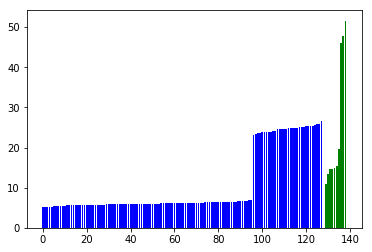

In [660]:


#printingFCME[0].sort()
#printingFCME[1].sort()
#printingConvME[0].sort()
#printingConvME[1].sort()
print(printingConvME[1])

#plotMEConvolution(printingConvME[0], printingConvME[1])
plotMEFullyConnected(printingFCME[0], printingFCME[1])
#plotME(printingConvME[1])
#plotME(printingConvME[1])

[85.7379026222229, 90.43793113708496, 95.11084922790528, 98.16531776428222, 106.55585374832154, 108.30533372879029, 112.69971153259277, 118.49580753326416, 121.55774440765381, 124.68165267944336, 125.00883766174316, 127.6857112121582, 131.14346092224122, 131.80042156219483, 139.08511531829834, 147.21158721923828]


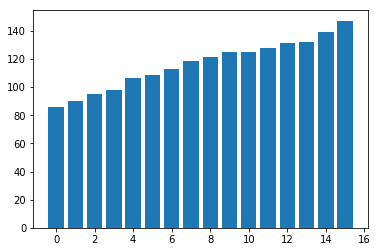

In [137]:
plotME(printingConvME[0])
#print(printingConvME[1])
#plotME(MEConvMatBorder[0])

In [116]:
#plotME(MEConvMatTruncate[0])

In [410]:
printingFCME

[[1.4061772906780243,
  1.4372267889976502,
  1.4590351915359496,
  1.4594764840602874,
  1.4687951457500459,
  1.4694240963459015,
  1.4836366283893585,
  1.4879925119876862,
  1.4892203140258788,
  1.493982845544815,
  1.4957626748085022,
  1.5104880666732787,
  1.5139175188541412,
  1.515634400844574,
  1.5170476269721984,
  1.519372169971466,
  1.5203617799282074,
  1.5257357573509216,
  1.5310826301574707,
  1.5319423305988311,
  1.5330543255805968,
  1.5433992540836334,
  1.548319664001465,
  1.5537010967731475,
  1.5551402831077576,
  1.5565727710723878,
  1.5572242188453673,
  1.5592043685913086,
  1.5643128740787506,
  1.5680928468704223,
  1.569286140203476,
  1.5769405233860017,
  1.5816425740718842,
  1.58227219581604,
  1.5830934631824494,
  1.5918955945968627,
  1.6040092945098876,
  1.60634011387825,
  1.6075753664970398,
  1.6086579489707946,
  1.611277985572815,
  1.6135731220245362,
  1.6161428534984588,
  1.6175353169441222,
  1.617626678943634,
  1.6177192616462708,

In [411]:
plotME(MEConvMatRTZ[0])

NameError: name 'MEConvMatRTZ' is not defined

In [412]:
MEConvMatCBA = []+ MEFullyConnectedMat  #ME values for CBA

In [413]:
MEConvMatBorder = []+ MEFullyConnectedMat #ME values for Border

In [414]:
MEConvMatTruncate = []+ MEFullyConnectedMat #ME values for Truncate

In [415]:
MEConvMatRTZ = []+ MEFullyConnectedMat #ME values for Truncate

### Filter Policy implementation

In [489]:
wConvNew = [] + wConv

In [519]:
wFullyConnectedNew = [] + wFc

In [524]:
newApproxFilters(MEConv1,wConvNew[0],wOrigConv[0])
newApproxFilters(MEConv2,wConvNew[1],wOrigConv[1])

the number of filters in this layer are
16
the number of filters in this layer are
36


In [542]:
wOrigFc[0].shape
newApproxFiltersForFullyConnected(MEFullyConnected1,wFullyConnectedNew[0],wOrigFc[0])
newApproxFiltersForFullyConnected(MEFullyConnected2,wFullyConnectedNew[1],wOrigFc[1])

the number of filters in this layer are
128
the number of filters in this layer are
10


In [528]:
wOrigFc[0].shape

(1764, 128)

In [543]:
assign_op = weightsConvMat[0].assign(wConvNew[0])
session.run(assign_op)

assign_op = weightsConvMat[1].assign(wConvNew[1])
session.run(assign_op)

assign_op = weightsFcMat[0].assign(wFullyConnectedNew[0])
session.run(assign_op)

assign_op = weightsFcMat[1].assign(wFullyConnectedNew[1])
session.run(assign_op)


array([[0.0000000e+00, 1.4081597e-06, 0.0000000e+00, ..., 0.0000000e+00,
        2.2947788e-06, 4.7683716e-07],
       [0.0000000e+00, 2.6598573e-06, 1.3001263e-06, ..., 2.7567148e-06,
        0.0000000e+00, 3.6275014e-06],
       [0.0000000e+00, 0.0000000e+00, 2.4400651e-06, ..., 0.0000000e+00,
        1.3411045e-06, 1.4305115e-06],
       ...,
       [0.0000000e+00, 2.9131770e-06, 0.0000000e+00, ..., 2.3208559e-06,
        0.0000000e+00, 1.9297004e-06],
       [0.0000000e+00, 1.0281801e-06, 0.0000000e+00, ..., 4.6864152e-06,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.6209822e-06,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [544]:
wConvNewCBA = [] + wConvNew #New filter values for CBA
wFcNewCBA = [] + wFullyConnectedNew

In [545]:
wConvNewBorder = [] + wConvNew #New filter values for Border
wFcNewBorder = [] + wFullyConnectedNew

In [546]:
wConvNewTruncate = [] + wConvNew #New filter values for Border
wFcNewTruncate = [] + wFullyConnectedNew

In [547]:
wConvNewRTZ = [] + wConvNew #New filter values for Border
wFcNewRTZ = [] + wFullyConnectedNew

In [548]:
wConvArr1 = [wConvNewCBA[0], wConvNewBorder[0], wConvNewTruncate[0],wConvNewRTZ[0]]
wFcArr1 = [wFcNewCBA[0], wFcNewBorder[0], wFcNewTruncate[0],wFcNewRTZ[0]]

In [550]:
wConvArr11 = [wConvNewCBA[0], wConvNewBorder[0]]
wFcArrl1 = [wFcNewCBA[0], wFcNewBorder[0]]

In [498]:
len(wConvArr1)

4

In [549]:
wConvArr2 = [wConvNewCBA[1], wConvNewBorder[1], wConvNewTruncate[1],wConvNewRTZ[1]]
wFcArr2 = [wFcNewCBA[1], wFcNewBorder[1], wFcNewTruncate[1],wFcNewRTZ[1]]

In [551]:
wConvArr22 = [wConvNewCBA[1], wConvNewBorder[1]]
wFcArr22 = [wFcNewCBA[1], wFcNewBorder[1]]

## Checksum Calculation

In [501]:
wOrigConv[1].shape


(5, 5, 16, 36)

In [121]:
def calculateCheckSum(wtMat,wOrig):
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]
        
        means = np.zeros((xlen,ylen,numChnls))
        meanAvg = np.zeros((xlen,ylen,numChnls))

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                means[:,:,c] += np.absolute(wtMat[:,:,c,i]-wOrig[:,:,c,i])
                
        meanAvg = np.float32( means/ numFilters) 
        return meanAvg
                

In [122]:
def calculateCheckSumFc(wtMat,wOrig):
        shape = wtMat.shape
        
        numChnls = shape[0]
        numFilters = shape[1]
        
        means = np.zeros((numChnls))
        meanAvg = np.zeros((numChnls))

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                means[c] += np.absolute(wtMat[c,i]-wOrig[c,i])
                
        meanAvg = np.float32( means/ numFilters) 
        return meanAvg

In [554]:
def calculateWeightedCheckSum(wtMat,wOrig,MEConv):
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]
        
        means = np.zeros((xlen,ylen,numChnls))
        meanAvg = np.zeros((xlen,ylen,numChnls))

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                means[:,:,c] += np.absolute(wtMat[:,:,c,i]-wOrig[:,:,c,i])*MEConv[i]
                
        meanAvg = np.float32( means/ numFilters) 
        return meanAvg

In [123]:
def calculateWeightedCheckSumFc(wtMat,wOrig,MEFc):
        shape = wtMat.shape
       
        
        numChnls = shape[0]
        numFilters = shape[1]
        
        means = np.zeros((numChnls))
        meanAvg = np.zeros((numChnls))

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                means[c] += np.absolute(wtMat[c,i]-wOrig[c,i])*MEConv[i]
                
        meanAvg = np.float32( means/ numFilters) 
        return meanAvg

In [560]:
checkCBA_1 = calculateCheckSum(wConv[0],wOrigConv[0])
checkCBAFc_1 = calculateCheckSumFc(wFc[0],wOrigFc[0])

In [561]:
checkCBA_2 = calculateCheckSum(wConv[1],wOrigConv[1])
checkCBAFc_2 = calculateCheckSumFc(wFc[1],wOrigFc[1])

In [563]:
checkBorder_1 = calculateCheckSum(wConv[0],wOrigConv[0])
checkBorderFc_1 = calculateCheckSumFc(wFc[0],wOrigFc[0])

In [507]:
checkRTZ_1[0]

array([[0.01237375],
       [0.01237375],
       [0.00518438],
       [0.00518438],
       [0.00292063]], dtype=float32)

In [564]:
checkBorder_2 = calculateCheckSum(wConv[1],wOrigConv[1])
checkBorderFc_2 =  calculateCheckSumFc(wFc[1],wOrigFc[1])

In [565]:
checkTruncate_1 = calculateCheckSum(wConv[0],wOrigConv[0])
checkTruncateFc_1 = calculateCheckSumFc(wFc[0], wOrigFc[0])

In [566]:
checkTruncate_2 = calculateCheckSum(wConv[1],wOrigConv[1])
checkTruncateFc_2 = calculateCheckSumFc(wFc[1], wOrigFc[1])

In [570]:
checkRTZ_1 = calculateCheckSum(wConv[0],wOrigConv[0])
checkRTZFc_1 = calculateCheckSumFc(wFc[0], wOrigFc[0])

In [568]:
checkRTZ_2 = calculateCheckSum(wConv[1],wOrigConv[1])
checkRTZFc_2 = calculateCheckSumFc(wFc[1], wOrigFc[1])

In [513]:
img = np.reshape(image1[10],[img_size,img_size])
kernel = meanAvgOrig - meanAvgConv1 
result = ndimage.correlate(img,kernel,mode = 'constant',cval = 0.0)

ValueError: cannot reshape array of size 1 into shape (28,28)

In [623]:
checkConv1 = [checkCBA_1,checkBorder_1, checkTruncate_1, checkRTZ_1]
print(checkConv1[2])
checkFc1 = [checkCBAFc_1,checkBorderFc_1, checkTruncateFc_1, checkRTZFc_1]

[[[0.01237375]
  [0.01237375]
  [0.00518438]
  [0.00518438]
  [0.00292063]]

 [[0.01237375]
  [0.01237375]
  [0.00518438]
  [0.00518438]
  [0.00292063]]

 [[0.02433562]
  [0.02433562]
  [0.00904   ]
  [0.00904   ]
  [0.00186813]]

 [[0.02433562]
  [0.02433562]
  [0.00904   ]
  [0.00904   ]
  [0.00186813]]

 [[0.00594   ]
  [0.00594   ]
  [0.00393313]
  [0.00393313]
  [0.00024437]]]


In [572]:
checkConv11 = [checkCBA_1,checkBorder_1]
checkFcl1 = [checkCBAFc_1,checkBorderFc_1]

In [573]:
checkConv2 = [checkCBA_2,checkBorder_2, checkTruncate_2, checkRTZ_2]
checkFc2 = [checkCBAFc_2,checkBorderFc_2, checkTruncateFc_2, checkRTZFc_2]

In [574]:
checkConv22 = [checkCBA_2,checkBorder_2]
checkFc22 = [checkCBAFc_2,checkBorderFc_2]

## Selecting Filter During Testing

In [518]:
imageTest = data.test.images[0]

feed_dict_test = {x: imageTest}

#Run throuh checksum list
imgTest = np.reshape(imageTest,[img_size,img_size])

kernel = meanAvgOrig - meanAvgConv1 

result = ndimage.correlate(img,kernel,mode = 'constant',cval = 0.0)

#minimum checksum
checkSumOut = np.sum(result)

#assign weigths
assignFilters(wConv,wOrigFc)

#Output of first layer
val_out1 = session.run(layer_con1_pool_relu, feed_dict=feed_dict)

#calculate chekcsum for second layer


NameError: name 'meanAvgOrig' is not defined

In [866]:
print(len(checkConv1))

4


fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)
fc2 size is 
(128,)


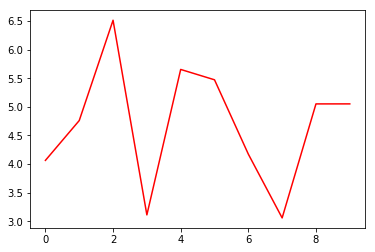

In [1055]:
imageTest = data.train.images[1000:1010]
xAxis = []
yAxisCB = []
yAxisR20 = []
yAxisBA = []
conv1Weights = []
conv2Weights = []
fc1Weights = []
fc2Weights = []
minSum = 1000000000

for i in range(0,len(imageTest)):
    feed_dict_test = {x: [imageTest[i]]}
    imgTest = np.reshape(imageTest[i],[img_size,img_size])
    checkSumOut = []
    checkSumOutFc = []
    for chckSum in checkSumConvLayer1:
        kernel = chckSum[:,:,0] 
       
        result = ndimage.correlate(imgTest,kernel,mode = 'constant',cval = 0.0)

        #minimum checksum
        checkSumOut.append(np.sum(result))
        
        ### doing the same for the fully connected layer
    for chckSumFc in checkSumFCLayer1:
        
        kernelFc = chckSumFc[0]
        #print("the kernel shape is ")
        #print(chckSumFc.shape)
        copy = np.array(imgTest)
        #copy.flatten()
        #print(chckSumFc.shape)
        copy = copy.flatten()
        #print(copy.shape)
        result = ndimage.correlate(copy, chckSumFc,mode = 'constant',cval = 0.0)
        checkSumOutFc.append(np.sum(result))
        
        
    minSumConv1 = 1000000000
    minSumFc = 1000000000
    indx = -1
    iterV = 0
    for chckSumVal in checkSumOut:
        
        if minSumConv1 > chckSumVal:
            #print(chckSumVal)
            minSumConv1 = chckSumVal
            indx = iterV
        iterV += 1

    conv1Weights.append(minSumConv1)
    
    indxFc = -1
    iterVFc = 0
    for chckSumValFc in checkSumOutFc:
        if minSumFc > chckSumValFc:
            minSumFc = chckSumValFc
            indxFc = iterVFc
        iterVFc += 1
    fc1Weights.append(minSumFc)
    xAxis.append(i)
    yAxisCB.append(checkSumOut[0])
    
    yAxisR20.append(checkSumOut[3])
    
    yAxisBA.append(checkSumOut[1])
    assign_op = weightsConvMat[0].assign(wConvArr1[indx])
    session.run(assign_op)
    assign_op = weightsFcMat[0].assign(wFcArr1[indxFc])
    session.run(assign_op)
    
   
    
    val_out1 = session.run(layer_conv1_pool_relu, feed_dict=feed_dict_test)
    val_out2 = session.run(layer_fc1, feed_dict = feed_dict_test)
    
    #print(val_out1.shape)
    shapeT = val_out1.shape

    #input_4d = tf.reshape(val_out1,[shapeT[0], shapeT[1], shapeT[2],1 ] )
    layr2Sum = []
    layr2SumFc = []
    for chckSum in checkSumConvLayer2:
        input_4d = tf.expand_dims(chckSum,3)

        checkSumOut2 = tf.nn.conv2d(input=np.float32(val_out1),
                     filter=input_4d,
                     strides=[1, 1, 1, 1],
                     padding='SAME')
        abc = session.run(checkSumOut2)
        layr2Sum.append(np.sum(abc))
    for chckSumFc in checkSumFCLayer2:
        kernelFc2 = chckSumFc[1] ## we are not using this kernel value
        currImage = np.array(imgTest)
        print("fc2 size is ")
        print(chckSumFc.shape)
        currImage = currImage.flatten()
        result = ndimage.correlate(currImage, chckSumFc, mode='constant', cval = 0.0)
        layr2SumFc.append(np.sum(result))
    minSumConv2 = 1000000000
    minSumFc2 = 1000000000
    itr = 0
    indx = -1
    for chckSumVal in layr2Sum:
        if minSumConv2 > chckSumVal:
            minSumConv2 = chckSumVal
            indx = itr
        itr += 1
    #print("layer2:",indx,"minSum:",layr2Sum)
    #print("\n")
    conv2Weights.append(minSumConv2)
    indxFc = -1
    itrFc = 0
    for chckSumValFc in layr2SumFc:
        if minSumFc2 > chckSumValFc:
            minSumFc2 = chckSumValFc
            indxFc = itrFc
        itrFc += 1
    fc2Weights.append(minSumFc2)
    assign_op = weightsConvMat[1].assign(wConvArr2[indx])
    session.run(assign_op)
    #print_test_accuracy()
    assign_op = weightsFcMat[1].assign(wFcArr2[indx])
    session.run(assign_op)
    
    

plt.plot(xAxis,yAxisCB,color='red')
#plt.plot(xAxis,yAxisR20,color='green')
#plt.plot(xAxis,yAxisBA,color='blue')
plt.show()


In [1056]:
conv1Weights.sort()

conv2Weights.sort()

fc1Weights.sort()
fc2Weights.sort()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


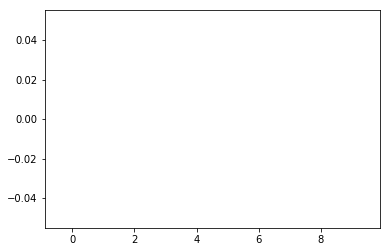

In [1098]:
plotME(fc2Weights)

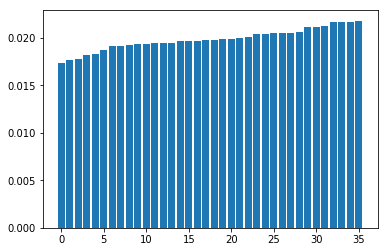

In [1066]:
plotME(postSubConvME[1])

In [467]:
imageTest = data.test.images[0:100]


feed_dict_test = {x: [imageTest[0]]}
imgTest = np.reshape(imageTest[0],[img_size,img_size])

print(imgTest.shape)
checkSumOut = []
#for chckSum in checkConv1:
kernel = checkConv1[0][:,:,0]
print(kernel.shape)
result = ndimage.correlate(imgTest,kernel,mode = 'constant',cval = 0.0)

(28, 28)
(5, 5)


In [468]:
def assignFilterSP(wConv):
    assign_op = weightsConvMat[0].assign(wConv)
    session.run(assign_op)

In [469]:
temp = session.run(checkSumOut2)
print(np.sum(temp))

0.0


## Visualization of Weights and Layers

In trying to understand why the convolutional neural network can recognize handwritten digits, we will now visualize the weights of the convolutional filters and the resulting output images.

### Helper-function for plotting convolutional weights

In [470]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for plotting the output of a convolutional layer

In [471]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Images

Helper-function for plotting an image.

In [472]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

Plot an image from the test-set which will be used as an example below.

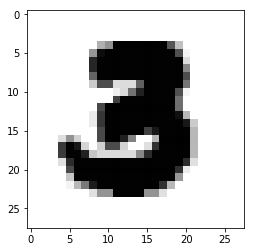

In [473]:
image1 = data.test.images[200]
plot_image(image1)

Plot another example image from the test-set.

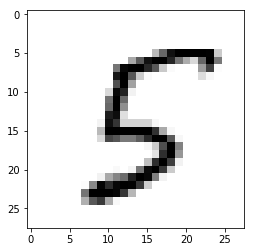

In [474]:
image2 = data.test.images[23]
plot_image(image2)

In [475]:
image2.shape

(784,)

### Convolution Layer 1

Now plot the filter-weights for the first convolutional layer.

Note that positive weights are red and negative weights are blue.

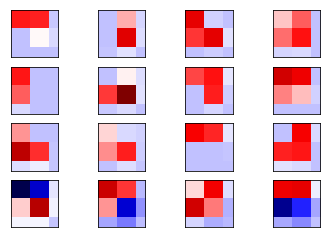

In [476]:
plot_conv_weights(weights=weights_conv1)

Applying each of these convolutional filters to the first input image gives the following output images, which are then used as input to the second convolutional layer. Note that these images are down-sampled to 14 x 14 pixels which is half the resolution of the original input image.

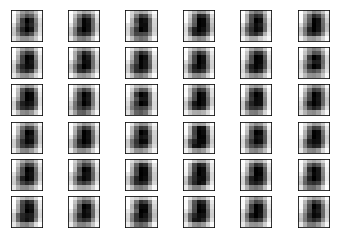

In [477]:
plot_conv_layer(layer=layer_conv2_pool_relu, image=image1)

The following images are the results of applying the convolutional filters to the second image.

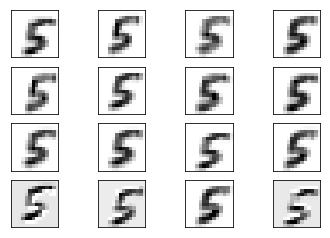

In [478]:
plot_conv_layer(layer=layer_conv1_pool_relu, image=image2)

It is difficult to see from these images what the purpose of the convolutional filters might be. It appears that they have merely created several variations of the input image, as if light was shining from different angles and casting shadows in the image.

### Convolution Layer 2

Now plot the filter-weights for the second convolutional layer.

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weigths for the first channel.

Note again that positive weights are red and negative weights are blue.

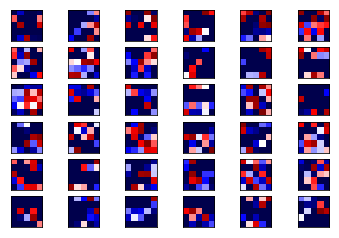

In [479]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

There are 16 input channels to the second convolutional layer, so we can make another 15 plots of filter-weights like this. We just make one more with the filter-weights for the second channel. 

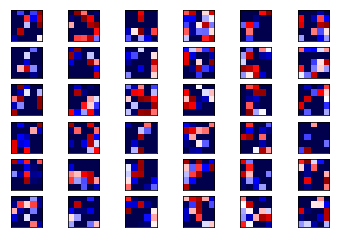

In [480]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

It can be difficult to understand and keep track of how these filters are applied because of the high dimensionality.

Applying these convolutional filters to the images that were ouput from the first conv-layer gives the following images.

Note that these are down-sampled yet again to 7 x 7 pixels which is half the resolution of the images from the first conv-layer.

In [481]:
#plot_conv_layer(layer=layer_conv1, image=image1)

And these are the results of applying the filter-weights to the second image.

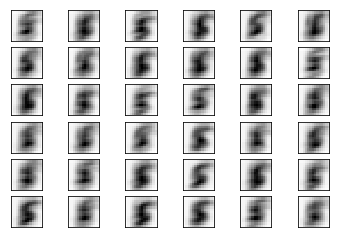

In [482]:
plot_conv_layer(layer=layer_conv2, image=image2)

From these images, it looks like the second convolutional layer might detect lines and patterns in the input images, which are less sensitive to local variations in the original input images.

These images are then flattened and input to the fully-connected layer, but that is not shown here.

### Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [483]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
#session.close()

## Conclusion

We have seen that a Convolutional Neural Network works much better at recognizing hand-written digits than the simple linear model in Tutorial #01. The Convolutional Network gets a classification accuracy of about 99%, or even more if you make some adjustments, compared to only 91% for the simple linear model.

However, the Convolutional Network is also much more complicated to implement, and it is not obvious from looking at the filter-weights why it works and why it sometimes fails.

So we would like an easier way to program Convolutional Neural Networks and we would also like a better way of visualizing their inner workings.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Do you get the exact same results if you run the Notebook multiple times without changing any parameters? What are the sources of randomness?
* Run another 10,000 optimization iterations. Are the results better?
* Change the learning-rate for the optimizer.
* Change the configuration of the layers, such as the number of convolutional filters, the size of those filters, the number of neurons in the fully-connected layer, etc.
* Add a so-called drop-out layer after the fully-connected layer. Note that the drop-out probability should be zero when calculating the classification accuracy, so you will need a placeholder variable for this probability.
* Change the order of ReLU and max-pooling in the convolutional layer. Does it calculate the same thing? What is the fastest way of computing it? How many calculations are saved? Does it also work for Sigmoid-functions and average-pooling?
* Add one or more convolutional and fully-connected layers. Does it help performance?
* What is the smallest possible configuration that still gives good results?
* Try using ReLU in the last fully-connected layer. Does the performance change? Why?
* Try not using pooling in the convolutional layers. Does it change the classification accuracy and training time?
* Try using a 2x2 stride in the convolution instead of max-pooling? What is the difference?
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.